In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [4]:

class Dataset(Dataset):
    def __init__(self, images_dir, masks_dir, imasks_dir, features_dir, transform=None, feature_dim=128):
        self.samples = []
        self.transform = transform
        self.feature_dim = min(feature_dim, 128)  # Ensure feature dimension is <= 128
        
        # If transform is not provided, use a default one
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
        
        # Create separate transform for masks if needed
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

        self.imask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        
        # Loop over each class (subdirectory)
        print(os.listdir(images_dir))
        for class_name in os.listdir(images_dir):
            class_path = os.path.join(images_dir, class_name)
            if not os.path.isdir(class_path):
                continue
                
            img_dir = os.path.join(class_path, 'occluded')
            mask_dir = os.path.join(class_path, 'masks')
            imask_dir = os.path.join(class_path, 'imasks')
            
            # Check if directories exist
            if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
                print(f"Warning: Missing directories for class {class_name}")
                continue
            # Check if directories exist
            if not os.path.exists(img_dir) or not os.path.exists(imask_dir):
                print(f"Warning: Missing directories for class {class_name}")
                continue
            # Check feature file
            feat_path = os.path.join(features_dir, class_name + '.npy')
            if not os.path.exists(feat_path):
                print(f"Warning: Missing feature file for class {class_name}")
                continue
                
            for img_name in os.listdir(img_dir):
                if img_name.endswith(('.jpg', '.png')):
                    base_name = os.path.splitext(img_name)[0]  # e.g., "happy_001"
                    mask_path = os.path.join(mask_dir, base_name + '_mask.png')
                    imask_path = os.path.join(imask_dir, base_name + '_imask.png')
                    
                    # Verify that the corresponding mask exists
                    if not os.path.exists(mask_path):
                        print(f"Warning: Missing mask for {img_name} in class {class_name}")
                        continue

                    if not os.path.exists(imask_path):
                        print(f"Warning: Missing mask for {img_name} in class {class_name}")
                        continue
            
                    self.samples.append({
                        'class': class_name,
                        'img_path': os.path.join(img_dir, img_name),
                        'mask_path': mask_path,
                        'imask_path': imask_path,
                        'feat_path': feat_path,
                        'img_name': img_name
                    })
        
        print(f"Dataset initialized with {len(self.samples)} samples")
                    
    def __len__(self):
        return len(self.samples)
    
    def _resize_feature(self, feature, target_dim):
        """Resize feature vector to target dimension"""
        feature_len = len(feature)
        
        if feature_len == target_dim:
            return feature
        elif feature_len > target_dim:
            # Truncate to target dimension
            return feature[:target_dim]
        else:
            # Pad with zeros to target dimension
            padded = np.zeros(target_dim)
            padded[:feature_len] = feature
            return padded
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        try:
            # Load image and mask
            image = Image.open(sample['img_path']).convert('RGB')
            mask = Image.open(sample['mask_path']).convert('L')
            imask = Image.open(sample['imask_path']).convert('RGB')
            
            
            # Apply transformations
            image = self.transform(image)
            mask = self.mask_transform(mask)
            imask = self.imask_transform(imask)
            
            
            # Binarize mask (0 or 1)
            mask = (mask > 0.5).float()
            
            # Load feature vector and resize to consistent dimension
            feature = np.load(sample['feat_path'])
            
            # If feature is multi-dimensional, flatten first
            if feature.ndim > 1:
                feature = feature.flatten()
                
            # Resize feature to target dimension
            feature = self._resize_feature(feature, self.feature_dim)
            feature = torch.tensor(feature, dtype=torch.float32)
            
            return {
                'occluded_image': image,
                'mask': mask,
                'imask' : imask, 
                'feature': feature,
                'image_name': sample['img_name'],
                'class_name': sample['class']
            }
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a default item in case of errors
            return {
                'occluded_image': torch.zeros(3, 256, 256),
                'mask': torch.zeros(1, 256, 256),
                'imask': torch.zeros(3, 256, 256),
                'feature': torch.zeros(self.feature_dim),
                'image_name': 'error_image.jpg',
                'class_name': 'error'
            }


['2820', '3227', '3699', '3745', '3782', '4887', '6568', '8968', '9152', '9256']
Dataset initialized with 5094 samples
Batch 0
Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 1, 256, 256])


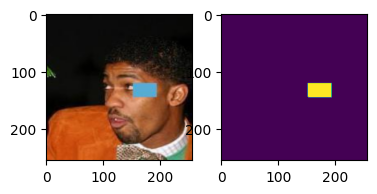

In [5]:
images_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
masks_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
imasks_dir='/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x'
features_dir='/home/jt/GAN/face_features'

# Create dataset with feature dimension of 64 (or any value <= 128)
dataset = Dataset(
    images_dir=images_dir, 
    masks_dir=masks_dir, 
    imasks_dir = imasks_dir,
    features_dir=features_dir,
    feature_dim=128  # Choose your desired dimension
)

# Create DataLoader with standard collate function (now safe)
loader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2
)

# Test the dataloader
for i, batch in enumerate(loader):
    print(f"Batch {i}")
    print(f"Images shape: {batch['occluded_image'].shape}")
    print(f"Masks shape: {batch['mask'].shape}")
    #print(f"Features shape: {batch['feature'].shape}")  # Should be [batch_size, feature_dim]
    #print(f"Classes: {batch['class_name']}")
    plt.subplot(1, 3, 1)
    plt.imshow(batch['occluded_image'][0].permute(1, 2, 0))

    plt.subplot(1, 3, 2)
    plt.imshow(batch['mask'][0].permute(1, 2, 0))
    #plt.subplot(1, 3, 3)
    #plt.imshow(batch['imask'][0].permute(1, 2, 0))
    
    # Break after first batch for testing
    if i == 0:
        break

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.dconv_down1 = DoubleConv(in_channels, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.ConvTranspose2d(512, 512, 2, stride=2)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return out  # Note: logits (no sigmoid yet)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
def compute_iou(pred, target):
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).sum().item()
    union = (pred | target).sum().item()
    return intersection / union if union > 0 else 1.0

def compute_dice(pred, target):
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).sum().item()
    return 2 * intersection / (pred.sum().item() + target.sum().item()) if pred.sum().item() + target.sum().item() > 0 else 1.0

In [49]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_iou = 0
    total_dice = 0
    count = 0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch in progress_bar:
        images = batch['occluded_image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Post-processing for evaluation
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for pred, target in zip(preds, masks):
            total_iou += compute_iou(pred, target)
            total_dice += compute_dice(pred, target)
            count += 1

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    avg_iou = total_iou / count
    avg_dice = total_dice / count

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f}")

Epoch 1/30 - Loss: 0.2121 | IoU: 0.6113 | Dice: 0.6772


Epoch 2/30 - Loss: 0.0763 | IoU: 0.7960 | Dice: 0.8468


Epoch 3/30 - Loss: 0.0369 | IoU: 0.8591 | Dice: 0.8990


Epoch 4/30 - Loss: 0.0213 | IoU: 0.8877 | Dice: 0.9219


Epoch 5/30 - Loss: 0.0136 | IoU: 0.9074 | Dice: 0.9362


Epoch 6/30 - Loss: 0.0090 | IoU: 0.9243 | Dice: 0.9495


Epoch 7/30 - Loss: 0.0074 | IoU: 0.9257 | Dice: 0.9508


Epoch 8/30 - Loss: 0.0054 | IoU: 0.9360 | Dice: 0.9580


Epoch 9/30 - Loss: 0.0040 | IoU: 0.9462 | Dice: 0.9660


Epoch 10/30 - Loss: 0.0043 | IoU: 0.9384 | Dice: 0.9597


Epoch 11/30 - Loss: 0.0029 | IoU: 0.9531 | Dice: 0.9709


Epoch 12/30 - Loss: 0.0029 | IoU: 0.9518 | Dice: 0.9697


Epoch 13/30 - Loss: 0.0021 | IoU: 0.9593 | Dice: 0.9755


Epoch 14/30 - Loss: 0.0028 | IoU: 0.9508 | Dice: 0.9695


Epoch 15/30 - Loss: 0.0029 | IoU: 0.9480 | Dice: 0.9660


Epoch 16/30 - Loss: 0.0021 | IoU: 0.9577 | Dice: 0.9739


Epoch 17/30 - Loss: 0.0014 | IoU: 0.9677 | Dice: 0.9811


Epoch 18/30 - Loss: 0.0013 | IoU: 0.9698 | Dice: 0.9827


Epoch 19/30 - Loss: 0.0012 | IoU: 0.9716 | Dice: 0.9840


Epoch 20/30 - Loss: 0.0028 | IoU: 0.9521 | Dice: 0.9697


Epoch 21/30 - Loss: 0.0017 | IoU: 0.9622 | Dice: 0.9769


Epoch 22/30 - Loss: 0.0012 | IoU: 0.9713 | Dice: 0.9836


Epoch 23/30 - Loss: 0.0011 | IoU: 0.9730 | Dice: 0.9848


Epoch 24/30 - Loss: 0.0024 | IoU: 0.9572 | Dice: 0.9732


Epoch 25/30 - Loss: 0.0016 | IoU: 0.9643 | Dice: 0.9785


Epoch 26/30 - Loss: 0.0011 | IoU: 0.9732 | Dice: 0.9847


Epoch 27/30 - Loss: 0.0010 | IoU: 0.9751 | Dice: 0.9861


Epoch 28/30 - Loss: 0.0009 | IoU: 0.9763 | Dice: 0.9869


Epoch 29/30 - Loss: 0.0009 | IoU: 0.9765 | Dice: 0.9870


Epoch 30/30 - Loss: 0.0027 | IoU: 0.9564 | Dice: 0.9720


In [68]:
image = "/home/jt/GAN/occluded_dataset/occluded_dataset_BIG_NEW_x/4887/occluded/4887_0_18.jpg"

In [69]:
from PIL import Image
from torchvision import transforms

# Load and transform image
img = Image.open(image).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to [0, 1] range and shape [3, H, W]
])
image = transform(img).unsqueeze(0).to(device)  # Add batch dimension: [1, 3, H, W]

In [70]:
output = torch.sigmoid(model(image))
binary_mask = (output > 0.5).float()

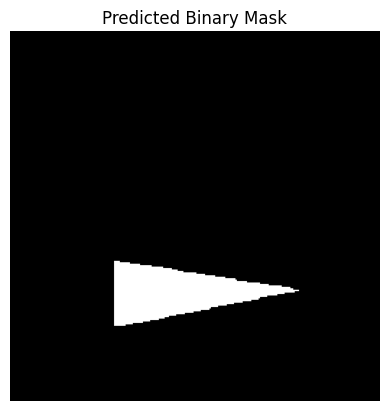

In [71]:
mask_np = binary_mask[0].squeeze().cpu().detach().numpy()

plt.imshow(mask_np, cmap='gray')
plt.axis('off')  # Optional: hide axes
plt.title("Predicted Binary Mask")
plt.show()

In [72]:
# Define the path where you want to save the model
checkpoint_path = "unet_30_epoch.pth"

# Save the model state_dict and optimizer state_dict
torch.save({
    'epoch': epoch,  # The current epoch, useful if resuming training
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,  # Optionally save the last epoch loss
}, checkpoint_path)

print(f"Model saved at {checkpoint_path}")

Model saved at unet_30_epoch.pth


In [ ]:
### reloading
# Initialize the model and optimizer again (use the same architecture)
model = UNet().to(device)  # Or your custom model architecture
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Same optimizer used during training

# Load the saved checkpoint
checkpoint = torch.load("unet_30_epoch.pth")

# Load model weights and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally, you can also retrieve the epoch and loss (for training continuation)
epoch = checkpoint['epoch']
epoch_loss = checkpoint['loss']

print(f"Model reloaded from checkpoint at epoch {epoch}.")

Model reloaded from checkpoint at epoch 29.
